步骤:
一. 数据分析
1. 下载并加载数据
2. 总体预览:了解每列数据的含义,数据的格式等
3. 数据初步分析,使用统计学与绘图:初步了解数据之间的相关性,为构造特征工程以及模型建立做准备

二. 特征工程
1.根据业务,常识,以及第二步的数据分析构造特征工程.
2.将特征转换为模型可以辨别的类型(如处理缺失值,处理文本进行等)

三. 模型选择
1.根据目标函数确定学习类型,是无监督学习还是监督学习,是分类问题还是回归问题等.
2.比较各个模型的分数,然后取效果较好的模型作为基础模型.

四. 模型融合

五. 修改特征和模型参数
1.可以通过添加或者修改特征,提高模型的上限.
2.通过修改模型的参数,是模型逼近上限

In [546]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
%matplotlib inline

In [547]:
train_df = pd.read_csv(r'F:\zhangtao_file\python_repository\machine_learning\titantic_example\train.csv')
test_df = pd.read_csv(r'F:\zhangtao_file\python_repository\machine_learning\titantic_example\test.csv')
IDtest = test_df["PassengerId"]

首先做数据概览，对数据有一个整体的认识

In [548]:
#查看数据的填充情况，发现年龄、客舱号码有缺失值
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [549]:
#查看数据都有什么字段
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [550]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 数据预处理
要做的主要包括如下内容，一般按照如下的顺序进行：
- 离群值的检测，对于显著偏移了数据集的点群，常需要在预处理中去除该类点；常用方法包括Tukey Method、均值方差法等
- 缺失值的填充：年龄、客舱号码、Embarked的缺失值处理；填充可以是用平均数、众数或者通过模型预测等；
- 看一下各特征量与目标变量Survived的关系，各个特征的相关系等。通过seaborn和matplotlib进行可视化查看。初步了解，哪些为主要特征，哪些为次要特征等；
- 分类变量和连续变量的分别处理；分类变量的哑变量处理；连续变量的分段处理等操作；
- 新特征的构造，比如数据中的Name中的Mr和Mrs可以做一些引申的特征；

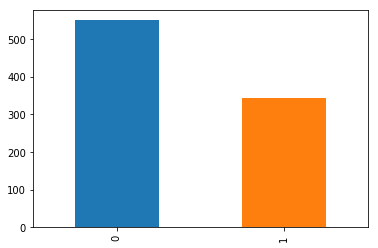

In [551]:
#Survived分布
train_df['Survived'].value_counts().to_frame()
train_df['Survived'].value_counts().to_frame()['Survived'].plot(kind='bar')

### 离群值的检测

In [552]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
这里使用Turkey方法来查找离群值；
Turkey方法是取得一组数据，对数据按照升序排列，取第一个四分位数Q1和第三个四分位数Q3，并计算二者之间的差值diff；
然后在原始数据中查找小于（Q1-diff）或者大于（Q3+diff）的数据，这些数据为离群值。

本程序是，查找某一行的所有特征数据中有两个以上离群值的样本，并在原始数据中去掉这些样本
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers

    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])
# 去掉离群值
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

F:\zhangtao_file\programs\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [553]:
#将训练集和测试集进行合并，因为都要做同样的特征处理
#因为要同时对训练集和测试集进行处理，这里对数据首先进行合并，然后最后训练模型前分开即可；
test_df['Survived']=0
train_len = len(train_df)
train_test_df = train_df.append(test_df)  

### 缺失值的填充

### 对于有缺失值的情况，可以考虑以下方法解决：
- 整体删除：整条记录删除，这种方法的主要优点之一是简单，但是这种方法降低了模型的准确性，因为它减少了样本大小。
- Mean（均值）/ Mode（众数）/ Median（中位数）估计，如果missing value占总体的比例非常小，那么直接填入Mean、Mode或者Median
- 模型预测：预测模型是处理缺失值的复杂方法之一， 通过创建一个预测模型来估计替代缺失值。 在这种情况下，我们将数据集分为两组：一组没有变量的缺失值，另一组有缺失值；如果missing value所占比例不算小也不算大时，采用该方法。这种办法，一般需要先考察要预测的缺失值都与哪些变量相关，选择相关性比较大的变量来进行预测。
- 变量映射到高维空间。比如性别，有男、女、缺失三种情况，则映射成3个变量：是否男、是否女、是否缺失；只有在样本量非常大的时候效果才好，否则会因为过于稀疏，效果很差。这样做的好处是完整保留了原始数据的全部信息、不用考虑缺失值、不用考虑线性不可分之类的问题。缺点是计算量大大提升。
- 缺失值当做一种新的特征引入；如缺失值对于目标影响过大，可考虑将缺失作为一种新的特征引入；如本模型中年龄缺失的死亡率为0.19，可将年龄是否缺失作为新的特征引入；

In [554]:
#Fare有一个缺失值，为测试集，而票价与仓位和港口有关
#票价与pclass和Embarked有关,所以用train分组后的平均数填充
train_test_df[pd.isnull(train_test_df["Fare"])]
#用pclass=3和Embarked=S的平均数14.644083来填充
train_df.groupby(by=["Pclass","Embarked"]).Fare.mean()
train_test_df["Fare"].fillna(14.435422,inplace=True)

In [555]:
#Embarked有两个缺失，用众数填充
#众数的函数为.mode
train_test_df['Embarked'].fillna(train_test_df['Embarked'].dropna().mode()[0],inplace=True)

### 特征分析

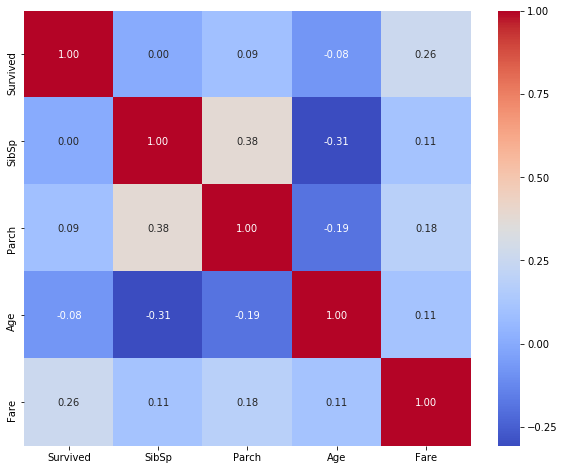

In [556]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
f, ax= plt.subplots(figsize = (10, 8))
g = sns.heatmap(train_df[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

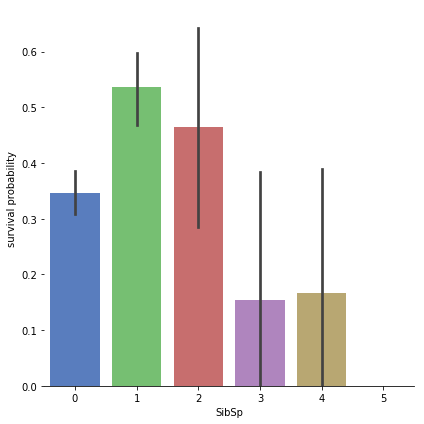

In [557]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

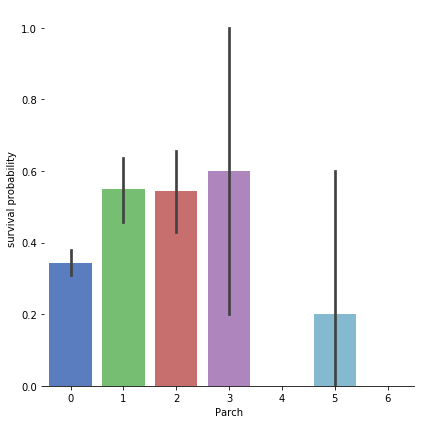

In [558]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

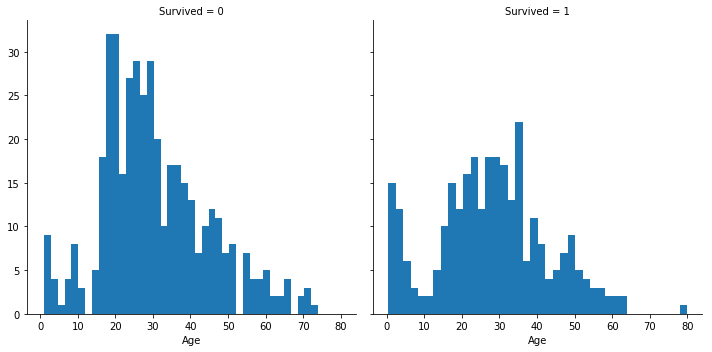

In [559]:
#年龄与Survived的关系
g = sns.FacetGrid(train_df, col='Survived',size=5)
g.map(plt.hist, 'Age', bins=40)

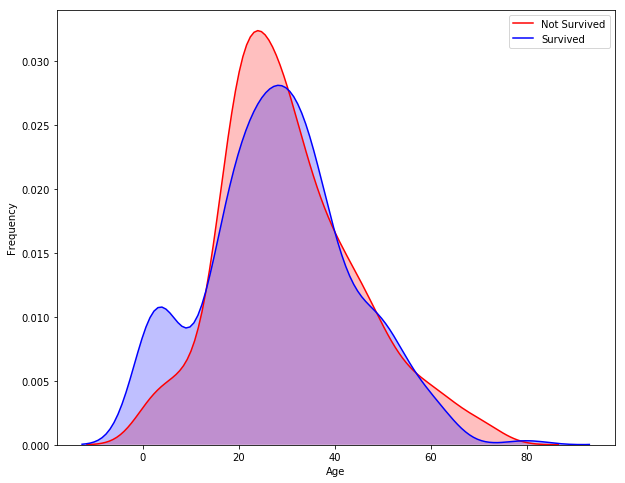

In [560]:
# Explore Age distibution 
f, ax= plt.subplots(figsize = (10, 8))
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 0) & (train_df["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 1) & (train_df["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

下面对于Fare的处理方法很具有代表性：
通过Fare变量的分布可以看出，数据并不呈现类似于Age的正态分布，也就是数据的分布存在倾斜；
在python中通过skew()统计数据分布偏斜方向和程度：其中正态分布的偏度为0，两侧尾部长度对称；通过观察左右边数据分布的尾部，可以看出来Fare变量为右偏态（右侧尾巴长）；一般在数据处理中需要对处于偏态的数据进行数学变换来改变数据的分布，常用的数据变换为log变换等

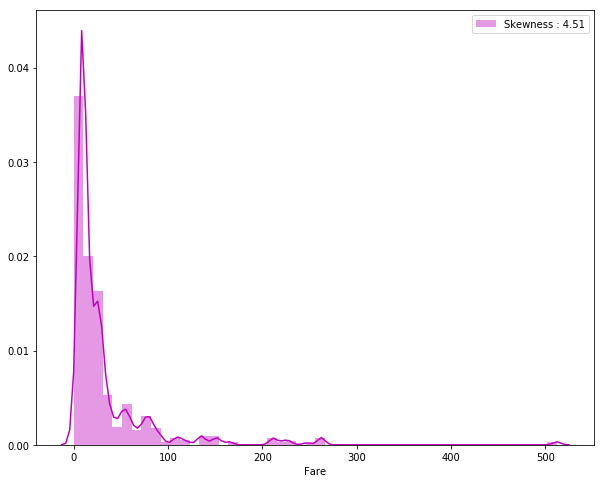

In [561]:
# Fare中有很多的异常值需要处理，
f, ax= plt.subplots(figsize = (10, 8))
g = sns.distplot(train_test_df["Fare"], color="m", label="Skewness : %.2f"%(train_test_df["Fare"].skew()))
g = g.legend(loc="best")

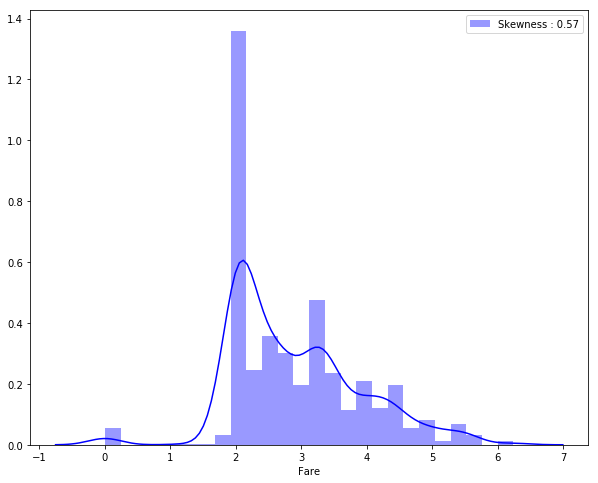

In [562]:
# Apply log to Fare to reduce skewness distribution
train_test_df["Fare"] = train_test_df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
f, ax= plt.subplots(figsize = (10, 8))
g = sns.distplot(train_test_df["Fare"], color="b", label="Skewness : %.2f"%(train_test_df["Fare"].skew()))
g = g.legend(loc="best")

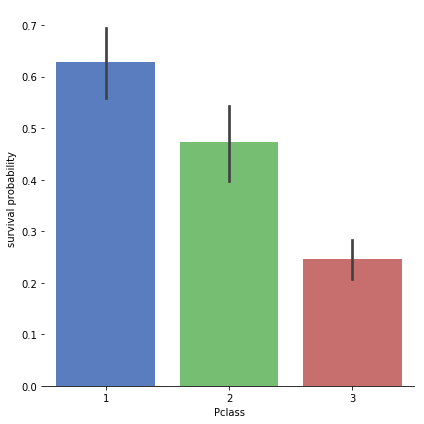

In [563]:
#自变量与因变量的单独关系分析
#Pclass与Survived的关系
g = sns.factorplot(x="Pclass",y="Survived",data=train_df,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

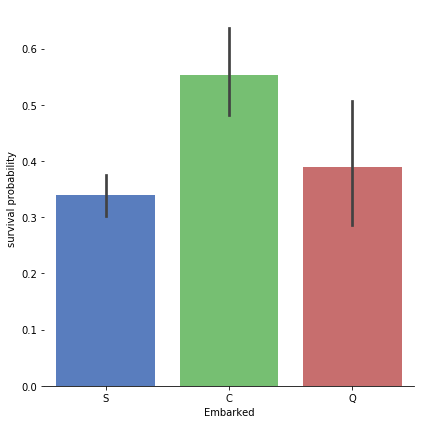

In [564]:
#登船港口与Survived的关系
g = sns.factorplot(x="Embarked", y="Survived",  data=train_df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

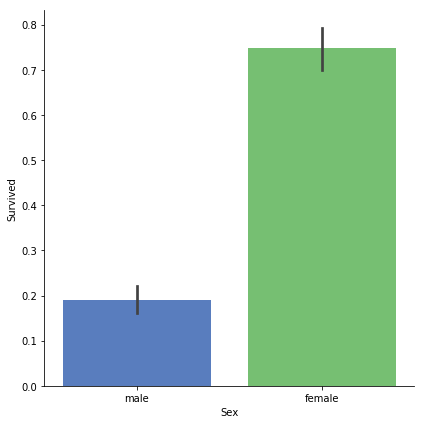

In [565]:
#性别与Survived的关系
sns.factorplot(data=train_df, x="Sex", y="Survived",size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

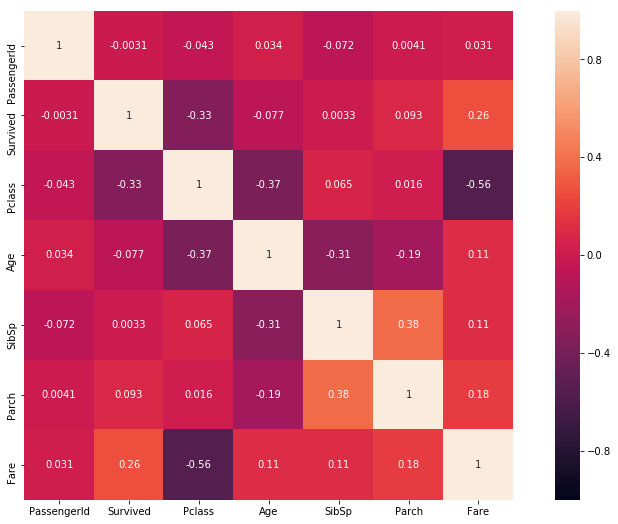

In [566]:
#多个变量间的相关性
# 画出相关性热力图
train_corr = train_df.corr()
a = plt.subplots(figsize=(15,9))#调整画布大小
a = sns.heatmap(train_corr, vmin=-1, vmax=1 , annot=True , square=True)#画热力图

### 特征处理  

In [567]:
#Age
#对于有缺失值的情况
#该列有大量缺失值,考虑用一个回归模型进行填充.
#在模型修改的时候,考虑到年龄缺失值可能影响死亡情况,用年龄是否缺失值来构造新特征

#"""增加新特征
#考虑年龄缺失值可能影响死亡情况,数据表明,年龄缺失的死亡率为0.19."""
train_test_df.loc[train_test_df["Age"].isnull()]['Survived'].mean()

# 所以用年龄是否缺失值来构造新特征 age_nan
train_test_df.loc[train_test_df["Age"].isnull() ,"age_nan"] = 1
train_test_df.loc[train_test_df["Age"].notnull() ,"age_nan"] = 0
train_test_df = pd.get_dummies(train_test_df,columns=['age_nan'])

In [568]:
# 利用其他组特征量，采用机器学习算法来预测Age
# 目标变量变为年龄，其他变量变为特征
predict_age = train_test_df[['Age','Parch','SibSp','Pclass']]
#将Age完整的项作为训练集、将Age缺失的项作为测试集。
predict_age_train = predict_age[predict_age['Age'].notnull()]
predict_age_test = predict_age[predict_age['Age'].isnull()]

#构建训练集合预测集的X和Y值
predict_age_X_train = predict_age_train.drop(['Age'], axis=1)
predict_age_Y_train = predict_age_train['Age']
predict_age_X_test = predict_age_test.drop(['Age'], axis=1)

# 先将数据标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
#用测试集训练并标准化
ss.fit(predict_age_X_train)
predict_age_X_train = ss.transform(predict_age_X_train)
predict_age_X_test = ss.transform(predict_age_X_test)

#使用贝叶斯预测年龄
from sklearn import linear_model
lin = linear_model.BayesianRidge()

lin.fit(predict_age_X_train,predict_age_Y_train)

linear_model.BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
        fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
        normalize=False, tol=0.001, verbose=False)

#利用loc将预测值填入数据集
train_test_df.loc[(train_test_df['Age'].isnull()), 'Age'] = lin.predict(predict_age_X_test)

#将年龄划分是个阶段10以下,10-18,18-30,30-50,50以上
train_test_df['Age_bin'] = pd.cut(train_test_df['Age'], bins=[(-1),10,18,30,50,100],labels=[1,2,3,4,5])
train_test_df.drop('Age',inplace=True,axis=1)  
train_test_df['Age_bin']  = train_test_df['Age_bin'].astype(int)
#train_test_df = pd.get_dummies(train_test_df,columns=['Age'])

In [569]:
#Title处理
train_test_df['Title'] = train_test_df.Name.str.extract('([A-Za-z]+\.)',expand=False)
train_test_df['Title'] = train_test_df['Title'].replace(['Lady.','Countess.','Don.','Capt.','Jonkheer.','Sir.','Dona.','Major.','Dr.','Rev.','Col.'],'Rare.')
train_test_df['Title'] = train_test_df['Title'].replace('Mlle.','Miss.')
train_test_df['Title'] = train_test_df['Title'].replace('Ms.','Miss.')
train_test_df['Title'] = train_test_df['Title'].replace('Mme.','Mrs.')
# Drop Name variable
train_test_df.drop(labels = ["Name"], axis = 1, inplace = True)

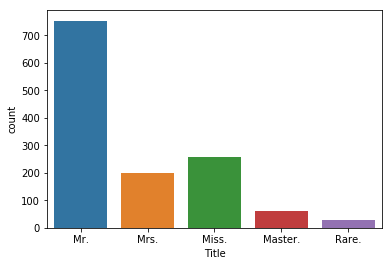

In [570]:
g = sns.countplot(train_test_df["Title"])

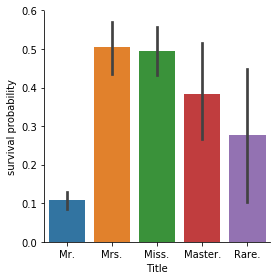

In [571]:
g = sns.factorplot(x="Title",y="Survived",data=train_test_df,kind="bar")
g = g.set_ylabels("survival probability")

In [572]:
#FamilySize处理
#Parch 和 SibSP组成一个新的特征，代表家庭中的成员数
train_test_df['FamilySize'] = train_test_df['SibSp'] + train_test_df['Parch'] + 1

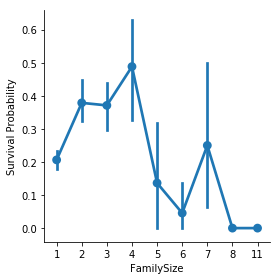

In [573]:
g = sns.factorplot(x="FamilySize",y="Survived",data = train_test_df)
g = g.set_ylabels("Survival Probability")

In [574]:
# Create new feature of family size
train_test_df['Single'] = train_test_df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
train_test_df['SmallF'] = train_test_df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
train_test_df['MedF'] = train_test_df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train_test_df['LargeF'] = train_test_df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [575]:
# 哑变量处理
train_test_df = pd.get_dummies(train_test_df, columns = ["Title"])
train_test_df = pd.get_dummies(train_test_df, columns = ["Embarked"], prefix="Em")

In [576]:
# Cabin处理
# Replace the Cabin number by the type of cabin 'X' if not
train_test_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train_test_df['Cabin'] ])

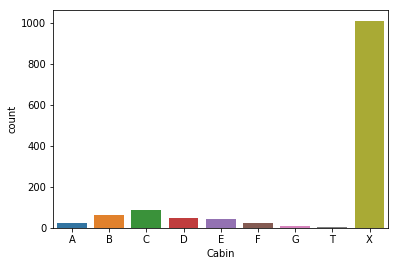

In [577]:
g = sns.countplot(train_test_df["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

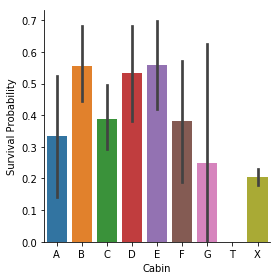

In [578]:
g = sns.factorplot(y="Survived",x="Cabin",data=train_test_df,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [579]:
train_test_df = pd.get_dummies(train_test_df, columns = ["Cabin"],prefix="Cabin")

In [580]:
#Ticket 取ticket的首字母，数字的用X来代替
Ticket = []
for i in list(train_test_df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
train_test_df["Ticket"] = Ticket


In [581]:
train_test_df = pd.get_dummies(train_test_df, columns = ["Ticket"], prefix="T")

In [582]:
train_test_df["Pclass"] = train_test_df["Pclass"].astype("category")
train_test_df = pd.get_dummies(train_test_df, columns = ["Pclass"],prefix="Pc")
train_test_df = pd.get_dummies(train_test_df, columns = ["Sex"],prefix="Sex")

In [583]:
train_test_df.head()

,Fare,Parch,PassengerId,SibSp,Survived,age_nan_0.0,age_nan_1.0,Age_bin,FamilySize,Single,...,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3,Sex_female,Sex_male
0,1.981001,0,1,1,0,1,0,3,2,0,...,0,0,0,0,0,0,0,1,0,1
1,4.266662,0,2,1,1,1,0,4,2,0,...,0,0,0,0,0,1,0,0,1,0
2,2.070022,0,3,0,1,1,0,3,1,1,...,0,0,0,0,0,0,0,1,1,0
3,3.972177,0,4,1,1,1,0,4,2,0,...,0,0,0,0,1,1,0,0,1,0
4,2.085672,0,5,0,0,1,0,4,1,1,...,0,0,0,0,1,0,0,1,0,1


In [584]:
#训练集和测试集分离
train_data = train_test_df[:train_df.shape[0]]
test_data = train_test_df[train_df.shape[0]:]

train_data_X = train_data.drop(['Survived','PassengerId'],axis=1)
train_data_Y = train_data['Survived']

test_data_X = test_data.drop(['Survived','PassengerId'],axis=1)

#### 模型训练
这里尝试使用多个单一模型和融合模型，来对训练集进行模型学习，并对测试集进行分类，并对比各算法的准确度；
通过交差验证以下10个算法的精度：
SVC
Decision Tree
AdaBoost
Random Forest
Extra Trees
Gradient Boosting
Multiple layer perceprton (neural network)
KNN
Logistic regression
Linear Discriminant Analysis
通过对各个模型精度的对比，选择若干的算法用于最终的集成学习算法。这里选用的是
SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers 

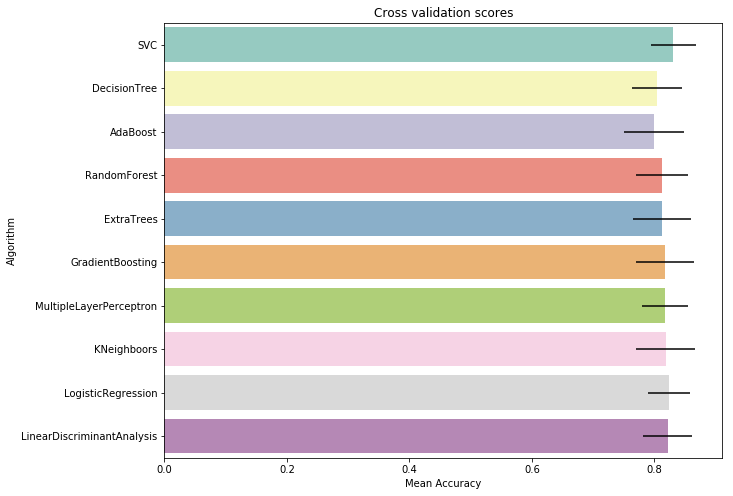

In [585]:
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, train_data_X, y = train_data_Y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

f, ax= plt.subplots(figsize = (10, 8))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [586]:
#对各个模型进行调参处理，选择最好的参数用于模型的训练。
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train_data_X,train_data_Y)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 155 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.7s finished


In [587]:
gsadaDTC.best_score_

0.8206583427922814

In [588]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(train_data_X,train_data_Y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   39.0s finished


0.8297389330306469

In [589]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train_data_X,train_data_Y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   42.8s finished


0.8342792281498297

In [590]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_data_X,train_data_Y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 337 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   23.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   23.4s finished


0.8251986379114642

In [591]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_data_X,train_data_Y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   24.0s finished


0.8308740068104427

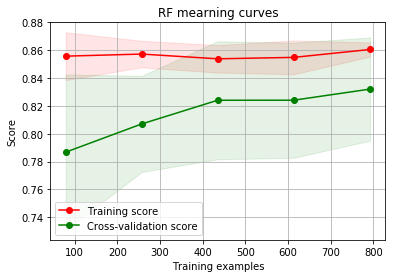

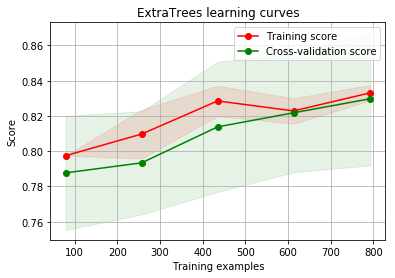

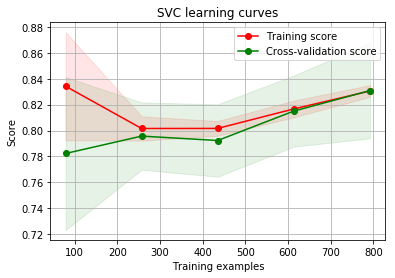

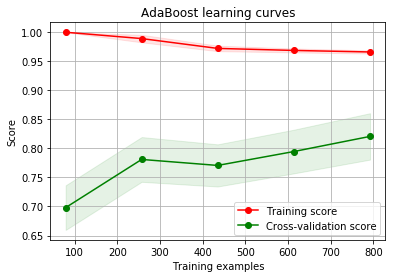

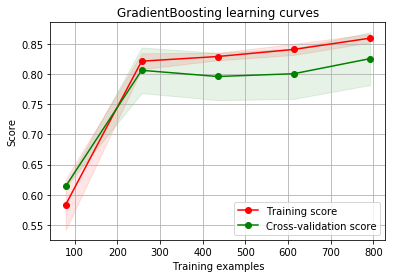

In [592]:
#绘制学习曲线

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

kfold = StratifiedKFold(n_splits=10)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",train_data_X,train_data_Y,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",train_data_X,train_data_Y,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",train_data_X,train_data_Y,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",train_data_X,train_data_Y,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",train_data_X,train_data_Y,cv=kfold)

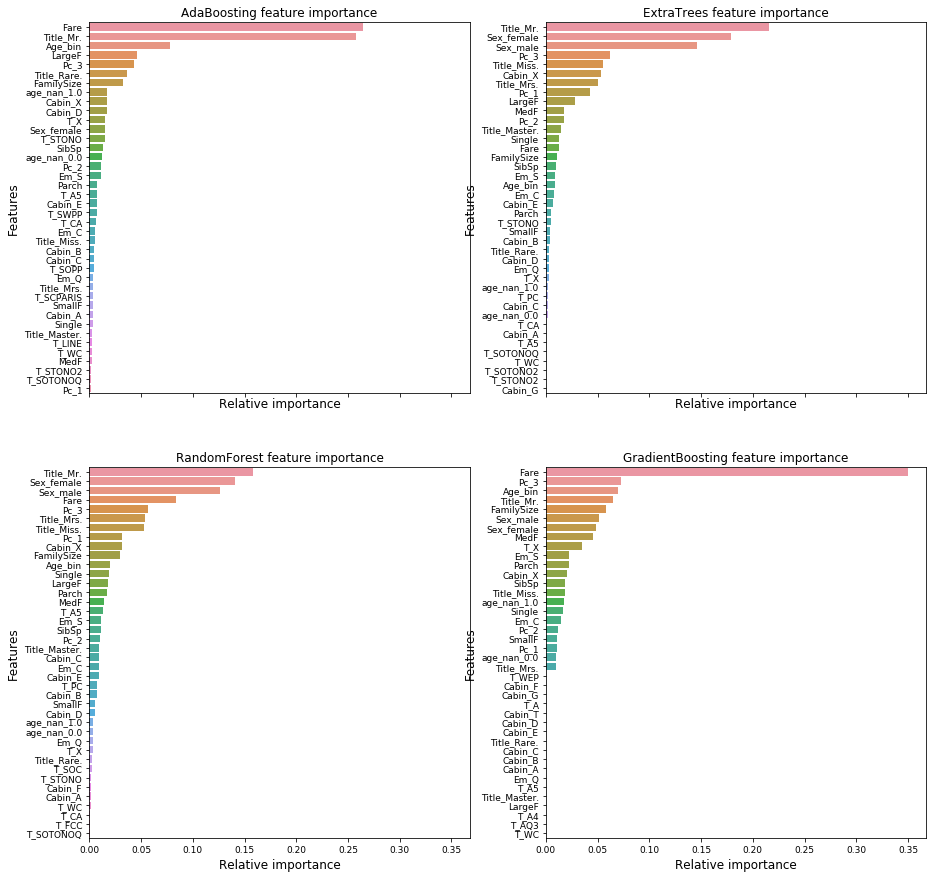

In [593]:
#Feature Importance
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_data_X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

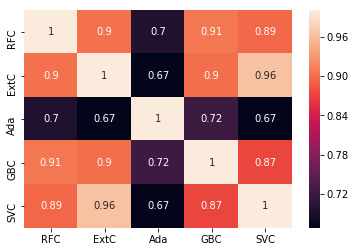

In [594]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_data_X), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_data_X), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_data_X), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_data_X), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_data_X), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [595]:
#Ensemble modeling
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_data_X, train_data_Y)

In [596]:
test_Survived = pd.Series(votingC.predict(test_data_X), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

F:\zhangtao_file\programs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [273]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

lr = LogisticRegression()
param = {'C':[0.001,0.01,0.1,1,10], "max_iter":[100,250]}
clf = GridSearchCV(lr, param,cv=5, n_jobs=-1, verbose=1, scoring="roc_auc")
clf.fit(train_data_X_sd, train_data_Y)

# 打印参数的得分情况
#print(clf.grid_scores_)
# 打印最佳参数
print(clf.best_params_)

# 将最佳参数传入训练模型
lr = LogisticRegression(max_iter=clf.best_params_['max_iter'],C=clf.best_params_['C'])
lr.fit(train_data_X_sd, train_data_Y)

scores = cross_val_score(lr, train_data_X_sd, train_data_Y, cv=4)  
print('accuracy:',np.mean(scores), scores)  
precisions = cross_val_score(lr, train_data_X_sd, train_data_Y, cv=4, scoring='precision')  
print('precison:', np.mean(precisions), precisions)  
recalls = cross_val_score(lr, train_data_X_sd, train_data_Y, cv=4, scoring='recall')  
print('recall:', np.mean(recalls), recalls)  
rocs = cross_val_score(lr, train_data_X_sd, train_data_Y, cv=4, scoring='roc_auc')  
print('roc_auc:', np.mean(rocs), rocs)  
# 输出结果
test_data["Survived"] = lr.predict(test_data_X_sd)
test_data[['PassengerId', 'Survived']].set_index('PassengerId').to_csv('LS5.csv')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000000019BFC780>>
Traceback (most recent call last):
  File "F:\zhangtao_file\programs\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


{'C': 0.01, 'max_iter': 100}
accuracy: 0.8080918943446971 [0.79464286 0.82511211 0.77927928 0.83333333]
precison: 0.746164836396235 [0.7173913  0.74226804 0.725      0.8       ]
recall: 0.7599863201094392 [0.76744186 0.8372093  0.68235294 0.75294118]
roc_auc: 0.8609391404779901 [0.83147961 0.87616703 0.84701589 0.88909403]


F:\zhangtao_file\programs\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [274]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=20,min_samples_leaf=2,max_depth=6,oob_score=True)
rf.fit(train_data_X,train_data_Y)

scores = cross_val_score(rf, train_data_X, train_data_Y,scoring='roc_auc')  
print('roc_auc:', np.mean(scores), scores)  

test_data["Survived"] = rf.predict(test_data_X)
RF = test_data[['PassengerId','Survived']].set_index('PassengerId')
RF.to_csv('RF.csv')

roc_auc: 0.8711373150544851 [0.83836641 0.88328061 0.89176493]


F:\zhangtao_file\programs\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [275]:
#特征重要性排序计算
feature_imp_sorted_rf = pd.DataFrame({'feature': test_data_X.columns,
                                          'importance':rf.feature_importances_}).sort_values('importance', ascending=False)

In [277]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=150,min_samples_leaf=3,max_depth=6)
xgb_model.fit(train_data_X,train_data_Y)


scores = cross_val_score(xgb_model, train_data_X, train_data_Y,scoring='roc_auc')  
print('roc_auc:', np.mean(scores), scores)  

test_data["Survived"] = xgb_model.predict(test_data_X)
XGB = test_data[['PassengerId','Survived']].set_index('PassengerId')
XGB.to_csv('XGB5.csv')



roc_auc: 0.8578835522321286 [0.82664653 0.88577318 0.86123095]


F:\zhangtao_file\programs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\zhangtao_file\programs\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [280]:
#融合模型
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01,max_iter=100)

import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=6,min_samples_leaf=2,n_estimators=100,num_round = 5)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20,min_samples_leaf=2,max_depth=6,oob_score=True)

from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf=2,max_depth=6,n_estimators=100)

vot = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gbdt',gbdt),('xgb',xgb_model)], voting='hard')
vot.fit(train_data_X,train_data_Y)

print('vot_accuracy:',vot.score(train_data_X,train_data_Y))

test_data["Survived"] = vot.predict(test_data_X)
test_data[['PassengerId','Survived']].set_index('PassengerId').to_csv('vot5.csv')

F:\zhangtao_file\programs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\zhangtao_file\programs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\zhangtao_file\programs\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [304]:
#stacking方法
# 划分train数据集,调用代码,把数据集名字转成和代码一样
X = train_data_X.values
X_predict = test_data_X.values
y = train_data_Y.values

'''模型融合中使用到的各个单模型'''
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

clfs = [LogisticRegression(C=0.01,max_iter=100),
        xgb.XGBClassifier(max_depth=6,n_estimators=100,num_round = 5),
        RandomForestClassifier(n_estimators=100,max_depth=6,oob_score=True),
        GradientBoostingClassifier(learning_rate=0.3,max_depth=6,n_estimators=100)]

# 创建n_folds
from sklearn.cross_validation import StratifiedKFold
n_folds = 5
skf = list(StratifiedKFold(y, n_folds))

# 创建零矩阵
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

# 建立模型
for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    print(j, clf)
    dataset_blend_test_j = np.zeros((X_predict.shape[0], len(skf)))
    for i, (train, test) in enumerate(skf):
        '''使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。'''
        print("Fold", i)
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

# 用建立第二层模型
clf2 = LogisticRegression(C=0.01,max_iter=100)
clf2.fit(dataset_blend_train, y)
y_submission = clf2.predict_proba(dataset_blend_test)[:, 1]


test_data["Survived"] = clf2.predict(dataset_blend_test)
test_data[['PassengerId','Survived']].set_index('PassengerId').to_csv('stack3.csv')

0 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=5, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=

F:\zhangtao_file\programs\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
